In [2]:
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, resolution_mm=2)


Dataset created in /home/csimmon2/nilearn_data/schaefer_2018



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


In [3]:
import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import image, input_data, datasets
from nilearn.connectome import ConnectivityMeasure
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
sub_info = sub_info[sub_info['group'] == 'control']
subs = sub_info['sub'].tolist()
#subs = ['sub-025']

run_num = 3
runs = list(range(1, run_num + 1))

# Define the number of ROIs for the Schaefer atlas
n_rois = 200  # You can adjust this value as needed

def apply_schaefer_atlas(subject_data, atlas_img, n_rois):
    # Resample atlas to subject space
    resampled_atlas = image.resample_to_img(atlas_img, subject_data, interpolation='nearest') # consider the interpolation method 
    
    # Extract time series data ##to check
    atlas_masker = input_data.NiftiLabelsMasker(labels_img=resampled_atlas, 
                                                standardize=True,
                                                memory='nilearn_cache', 
                                                verbose=0)
    time_series = atlas_masker.fit_transform(subject_data)
    
    return time_series

def create_connectivity_matrix(ss):
    logging.info(f"Processing subject: {ss}")
    
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, yeo_networks=7, resolution_mm=2) ###7???
    atlas_img = atlas.maps
    
    all_runs_data = []
    
    for rn in runs:
        # Load subject data for this run
        run_path = f'{raw_dir}/{ss}/ses-01/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/filtered_func_data_reg.nii.gz'
        if not os.path.exists(run_path):
            logging.warning(f'Run data not found: {run_path}')
            continue
        
        subject_img = nib.load(run_path)
        
        # Apply Schaefer atlas and extract time series
        run_data = apply_schaefer_atlas(subject_img, atlas_img, n_rois)
        all_runs_data.append(run_data)
    
    if not all_runs_data:
        logging.warning(f'No valid run data found for subject {ss}')
        return None
    
    # Concatenate runs
    full_time_series = np.concatenate(all_runs_data, axis=0)
    
    # Compute connectivity matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    connectivity_matrix = correlation_measure.fit_transform([full_time_series])[0]
    
    return connectivity_matrix

def main():
    for ss in subs:
        connectivity_matrix = create_connectivity_matrix(ss)
        if connectivity_matrix is not None:
            # Save the connectivity matrix
            output_dir = f'{results_dir}/connectivity_matrices'
            os.makedirs(output_dir, exist_ok=True)
            np.save(f'{output_dir}/{ss}_connectivity_matrix.npy', connectivity_matrix)
            logging.info(f'Saved connectivity matrix for {ss}')

if __name__ == "__main__":
    main()

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
2024-10-22 22:34:48,065 - INFO - Processing subject: sub-025


KeyboardInterrupt: 

Matrix Diagnostics:
Shape: (200, 200)
Value range: -0.631 to 1.000
Mean connectivity: 0.131
Matrix is symmetric: True

Network-wise average internal correlations:
DefaultMode: 0.182
Control: 0.225
Limbic: 0.129
SalVentAttn: 0.164
DorsAttn: 0.205
SomMot: 0.157
Visual: 0.166


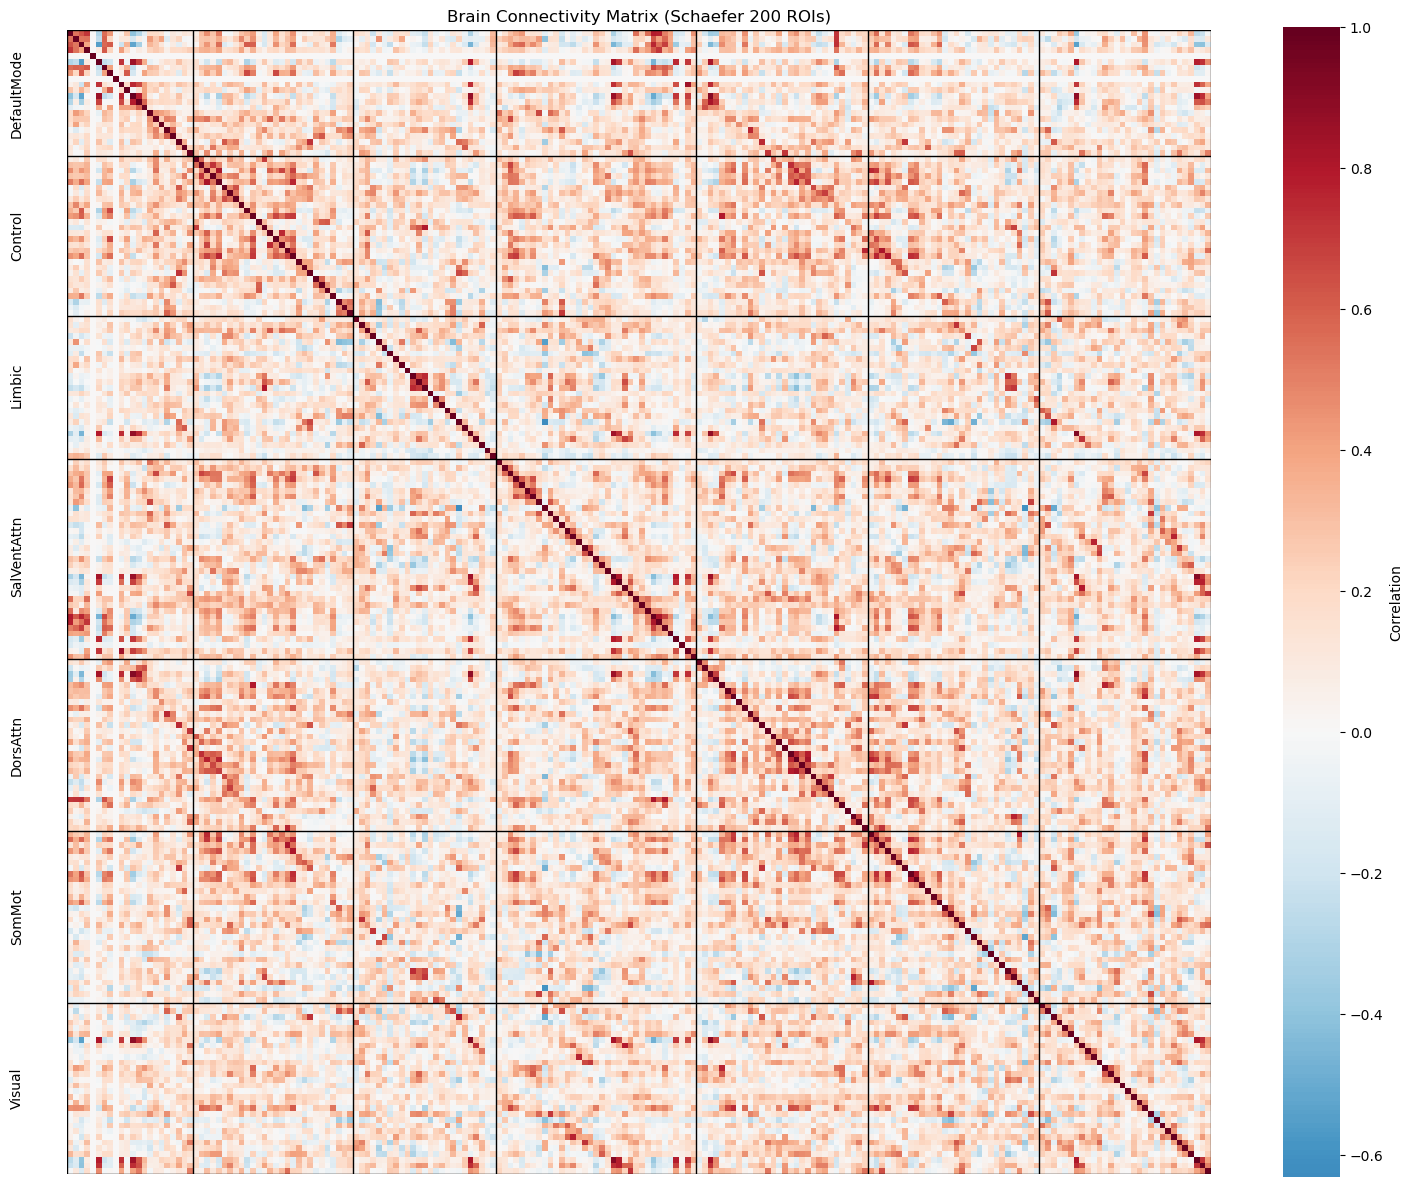

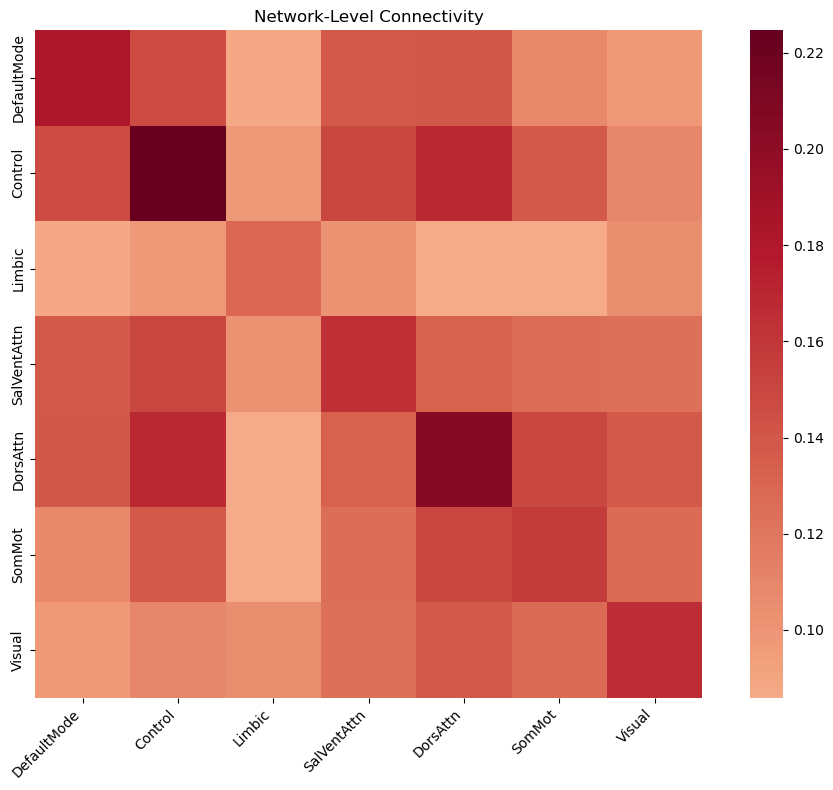

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_connectivity_matrix(file_path):
    # Load and verify matrix
    matrix = np.load(file_path)
    print(f"Matrix Diagnostics:")
    print(f"Shape: {matrix.shape}")
    print(f"Value range: {matrix.min():.3f} to {matrix.max():.3f}")
    print(f"Mean connectivity: {matrix.mean():.3f}")
    
    # Verify symmetry
    is_symmetric = np.allclose(matrix, matrix.T)
    print(f"Matrix is symmetric: {is_symmetric}")
    
    # Plot improved visualization
    plt.figure(figsize=(15, 12))
    
    # Network boundaries for Schaefer 200-7Network
    networks = [0, 22, 50, 75, 110, 140, 170, 200]
    network_labels = [
        'DefaultMode',
        'Control',
        'Limbic',
        'SalVentAttn',
        'DorsAttn',
        'SomMot',
        'Visual'
    ]
    
    # Create heatmap
    sns.heatmap(matrix,
                cmap='RdBu_r',
                center=0,
                square=True,
                xticklabels=False,  # Remove for clarity
                yticklabels=False,
                cbar_kws={'label': 'Correlation'})
    
    # Add network boundaries
    for idx in networks:
        plt.axhline(y=idx, color='black', linewidth=1)
        plt.axvline(x=idx, color='black', linewidth=1)
    
    # Add network labels
    for i in range(len(networks)-1):
        mid_point = (networks[i] + networks[i+1]) // 2
        plt.text(-10, mid_point, network_labels[i], 
                rotation=90, verticalalignment='center')
    
    plt.title('Brain Connectivity Matrix (Schaefer 200 ROIs)')
    
    # Add network-wise correlation information
    print("\nNetwork-wise average internal correlations:")
    for i in range(len(networks)-1):
        network_data = matrix[networks[i]:networks[i+1], networks[i]:networks[i+1]]
        mean_corr = np.mean(network_data)
        print(f"{network_labels[i]}: {mean_corr:.3f}")
    
    plt.tight_layout()
    plt.show()
    
    # Create a simplified version showing network-level connectivity
    network_matrix = np.zeros((7, 7))
    for i in range(len(networks)-1):
        for j in range(len(networks)-1):
            block = matrix[networks[i]:networks[i+1], networks[j]:networks[j+1]]
            network_matrix[i, j] = np.mean(block)
    
    # Plot network-level connectivity
    plt.figure(figsize=(10, 8))
    sns.heatmap(network_matrix,
                cmap='RdBu_r',
                center=0,
                square=True,
                xticklabels=network_labels,
                yticklabels=network_labels)
    plt.title('Network-Level Connectivity')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Run the analysis
file_path = 'results/connectivity_matrices/sub-025_connectivity_matrix.npy'
analyze_connectivity_matrix(file_path)

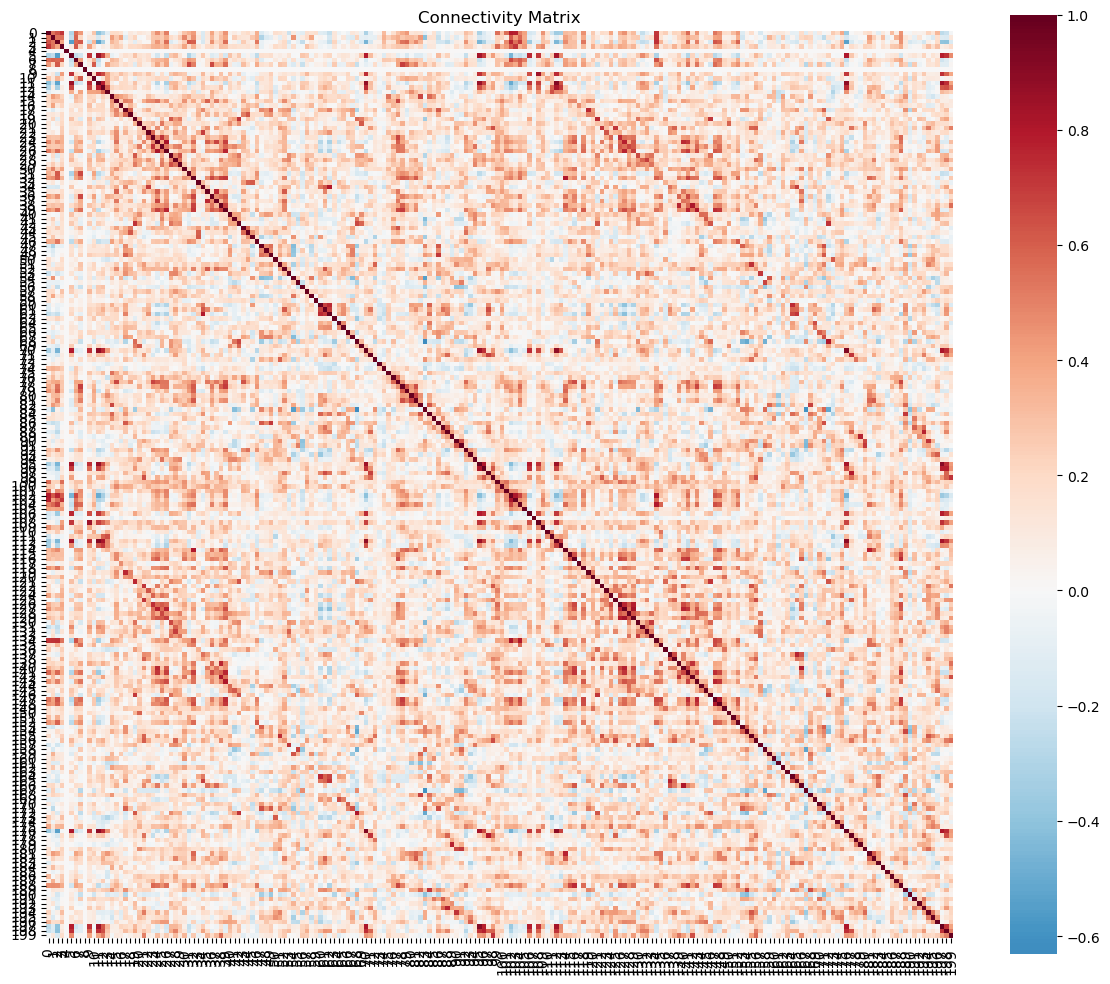

Matrix shape: (200, 200)

Matrix values range: -0.63092643 to 1.0

First few rows and columns:
[[1.    0.543 0.629 0.72  0.   ]
 [0.543 1.    0.532 0.539 0.   ]
 [0.629 0.532 1.    0.392 0.   ]
 [0.72  0.539 0.392 1.    0.   ]
 [0.    0.    0.    0.    1.   ]]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'results/connectivity_matrices/sub-025_connectivity_matrix.npy'

def view_connectivity_matrix(file_path):
    # Load the connectivity matrix
    matrix = np.load(file_path)
    
    # Create a figure with a larger size
    plt.figure(figsize=(12, 10))
    
    # Create heatmap using seaborn
    sns.heatmap(matrix, 
                cmap='RdBu_r',  # Red-Blue diverging colormap
                center=0,       # Center the colormap at 0
                square=True,    # Make the plot square
                xticklabels=True,
                yticklabels=True)
    
    plt.title('Connectivity Matrix')
    plt.tight_layout()
    plt.show()

# Use the function
file_path = 'results/connectivity_matrices/sub-025_connectivity_matrix.npy'
view_connectivity_matrix(file_path)

# If you want to see the raw numbers:
matrix = np.load(file_path)
print("Matrix shape:", matrix.shape)
print("\nMatrix values range:", np.min(matrix), "to", np.max(matrix))
print("\nFirst few rows and columns:")
np.set_printoptions(precision=3, suppress=True)
print(matrix[:5, :5])  # Show first 5x5 elements

ValueError: 'adjacency_matrix' is supposed to have shape (n, n). Its shape was ()

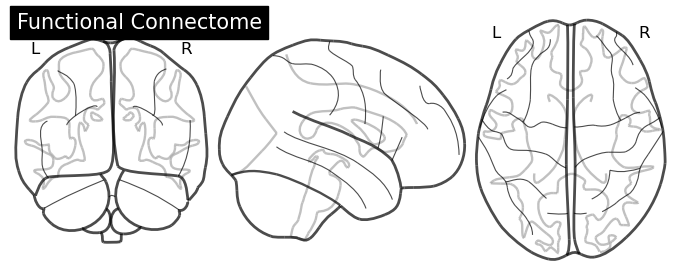

In [9]:
from nilearn import plotting

def visualize_connectome(connectivity_matrix, atlas):
    coords = plotting.find_parcellation_cut_coords(labels_img=atlas.maps)
    plotting.plot_connectome(connectivity_matrix, coords, 
                             title='Functional Connectome')
    plt.savefig(f'{output_dir}/{ss}_connectome.png')
    #plt.close()

connectivity_matrix = f'results/connectivity_matrices/sub-025_connectivity_matrix.npy'
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, resolution_mm=2)

visualize_connectome(connectivity_matrix, atlas)
# Call this function after creating the connectivity matrix in your main function

NameError: name 'plt' is not defined

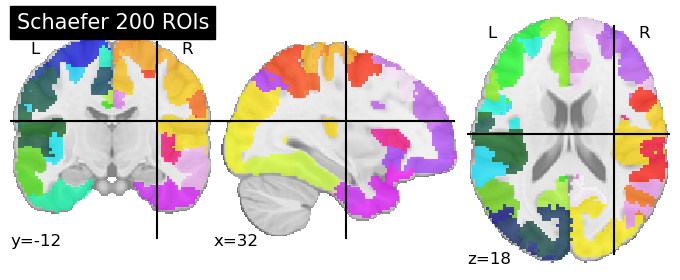

In [4]:
from nilearn import plotting

def visualize_atlas(atlas):
    plotting.plot_roi(atlas.maps, title='Schaefer 200 ROIs')
    plt.savefig(f'{output_dir}/schaefer_200_atlas.png')
    #plt.close()

# Call this function after loading the atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
visualize_atlas(atlas)